In [1]:
import os
import cv2
import numpy as np
import torch
from skimage import transform
import torch.nn.functional as F
from skimage import io
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO
from segment_anything import sam_model_registry

In [2]:
# Visualization functions
def show_mask(mask, ax):
    color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])  # Yellow with transparency
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='red', facecolor=(0, 0, 0, 0), lw=1))  # Set lw=1 for thin boxes


@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_original, original_size):
    box_torch = torch.as_tensor(box_original, dtype=torch.float, device=img_embed.device)
    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch[None, None, :],
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed,
        image_pe=medsam_model.prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=False,
    )
    low_res_pred = torch.sigmoid(low_res_logits)
    mask_resized = F.interpolate(low_res_pred, size=original_size, mode="bilinear", align_corners=False)
    return (mask_resized.squeeze().cpu().numpy() > 0.5).astype(np.uint8)

In [3]:
# Load MedSAM model
MedSAM_CKPT_PATH = r"C:\teeth segmentation\Main task\MedSam\medsam_vit_b.pth"
device = "cpu"

checkpoint = torch.load(MedSAM_CKPT_PATH, map_location=torch.device('cpu'))
medsam_model = sam_model_registry['vit_b']()
medsam_model.load_state_dict(checkpoint)
medsam_model = medsam_model.to(device)
medsam_model.eval()

# Load YOLO model
yolo_model = YOLO(r"C:\teeth segmentation\Main task\MedSam\runs\detect\teeth_model47\weights\best.pt")

In [4]:
# Process an image
img_path = r"C:\Users\navid\Desktop\train_18.png"
img_np = io.imread(img_path)
img_3c = np.repeat(img_np[:, :, None], 3, axis=-1) if len(img_np.shape) == 2 else img_np
H, W, _ = img_3c.shape

# Resize image for YOLO
img_resized = np.array(Image.fromarray(img_3c).resize((1024, 1024)))
H_resized, W_resized, _ = img_resized.shape
resize_scale = (W_resized / W, H_resized / H)

# Convert the resized image to a tensor for MedSAM
#img_tensor = torch.tensor(img_resized).float().permute(2, 0, 1).unsqueeze(0).to(device)
img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
img_1024 = (img_1024 - img_1024.min()) / np.clip(img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None)
img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)

# Generate image embedding
with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_1024_tensor)

# Run YOLO on the original image
yolo_results = yolo_model.predict(img_3c, imgsz=1024, conf=0.5)

# Prepare the combined mask
all_masks = np.zeros((H_resized, W_resized), dtype=np.uint8)


0: 512x1024 27 tooths, 38.7ms
Speed: 11.7ms preprocess, 38.7ms inference, 71.9ms postprocess per image at shape (1, 3, 512, 1024)


In [5]:
for result in yolo_results:
    if result.boxes is None:
        continue

    for box in result.boxes.xyxy:
        x_min, y_min, x_max, y_max = map(float, box.cpu().numpy())

        # Adjust bounding box coordinates for resized image
        x_min_resized = int(x_min * resize_scale[0])
        y_min_resized = int(y_min * resize_scale[1])
        x_max_resized = int(x_max * resize_scale[0])
        y_max_resized = int(y_max * resize_scale[1])

        # Define the bounding box in resized coordinates
        box_resized = [x_min_resized, y_min_resized, x_max_resized, y_max_resized]

        # Run MedSAM inference for this bounding box
        medsam_seg = medsam_inference(medsam_model, image_embedding, box_resized, original_size=(H_resized, W_resized))

        # Add to combined mask
        all_masks = np.maximum(all_masks, medsam_seg)

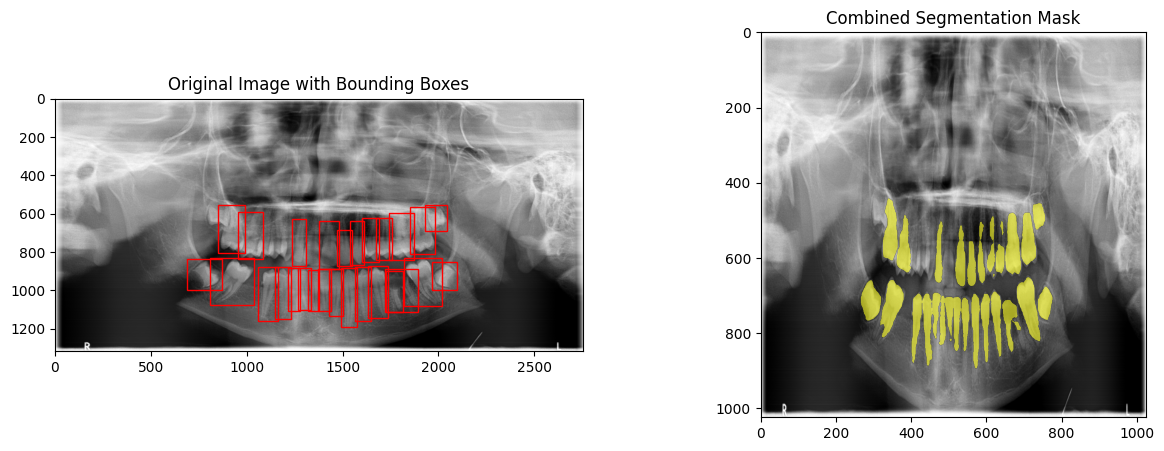

In [6]:
# Display the results
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Original Image with YOLO Bounding Boxes
axs[0].imshow(img_3c)
axs[0].set_title("Original Image with Bounding Boxes")
for result in yolo_results:
    if result.boxes is not None:
        for box in result.boxes.xyxy:
            x_min, y_min, x_max, y_max = map(float, box.cpu().numpy())
            show_box([x_min, y_min, x_max, y_max], axs[0])

# Combined Segmentation Mask
axs[1].imshow(img_resized, cmap='gray')
show_mask(all_masks, axs[1])
axs[1].set_title("Combined Segmentation Mask")

plt.show()

Text(0.5, 1.0, 'Combined Segmentation Mask')

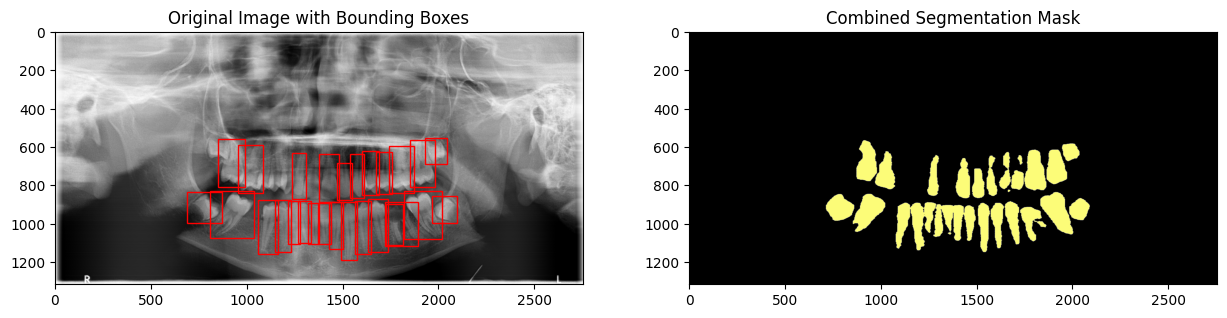

In [43]:
# Display the results
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Original Image with YOLO Bounding Boxes
axs[0].imshow(img_3c)
axs[0].set_title("Original Image with Bounding Boxes")
for result in yolo_results:
    if result.boxes is not None:
        for box in result.boxes.xyxy:
            x_min, y_min, x_max, y_max = map(float, box.cpu().numpy())
            show_box([x_min, y_min, x_max, y_max], axs[0])

# Resize the MedSAM segmentation mask to match the original image size
original_size = img_3c.shape[:2]  # Height and Width of the original image
resized_mask = cv2.resize(all_masks, (original_size[1], original_size[0]))  # Resize to (Width, Height)

# Normalize the mask values for visualization
normalized_mask = (resized_mask - resized_mask.min()) / (resized_mask.max() - resized_mask.min() + 1e-5)  # Avoid division by zero

# Combined Segmentation Mask
axs[1].imshow(normalized_mask, cmap='gray')
show_mask(normalized_mask, axs[1])
axs[1].set_title("Combined Segmentation Mask")


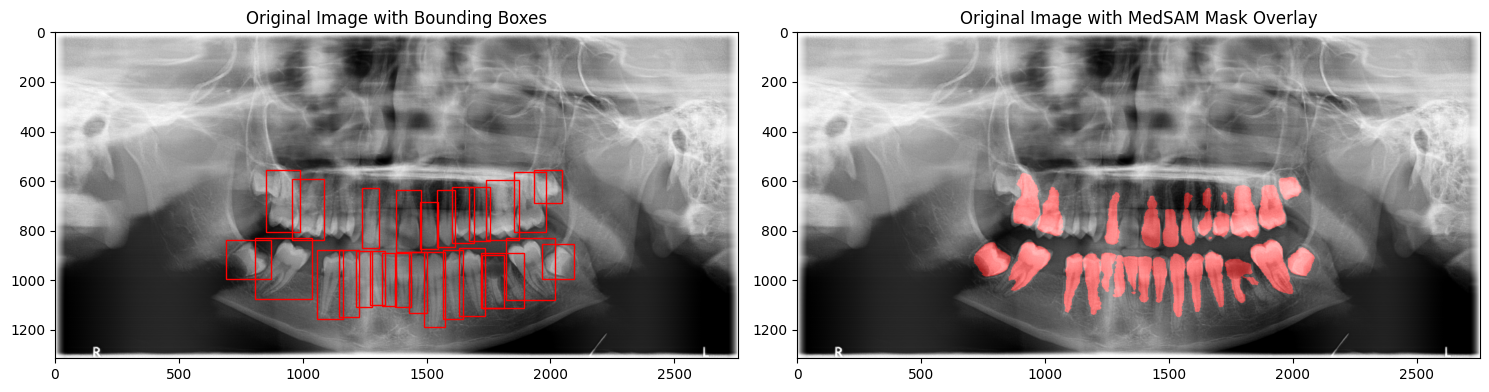

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Display the results
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Original Image with YOLO Bounding Boxes
axs[0].imshow(img_3c)
axs[0].set_title("Original Image with Bounding Boxes")
for result in yolo_results:
    if result.boxes is not None:
        for box in result.boxes.xyxy:
            x_min, y_min, x_max, y_max = map(float, box.cpu().numpy())
            show_box([x_min, y_min, x_max, y_max], axs[0])

# Resize MedSAM mask to the original image size
original_size = img_3c.shape[:2]  # Height and Width of the original image
resized_mask = cv2.resize(all_masks, (original_size[1], original_size[0]), interpolation=cv2.INTER_NEAREST)  # Resize to match (Width, Height)

# Normalize the resized mask for visualization
resized_mask = resized_mask.astype(float)
normalized_mask = (resized_mask - resized_mask.min()) / (resized_mask.max() - resized_mask.min() + 1e-5)

# Convert original image to RGBA for transparency support
img_with_mask = img_3c.copy()
img_with_mask = cv2.cvtColor(img_with_mask, cv2.COLOR_BGR2RGBA)

# Create a colorized version of the mask
mask_color = np.zeros_like(img_with_mask)
mask_color[:, :, 0] = normalized_mask * 255  # Apply the mask in the red channel (for example)
mask_color[:, :, 1] = normalized_mask * 0   # No green channel
mask_color[:, :, 2] = normalized_mask * 0   # No blue channel
mask_color[:, :, 3] = normalized_mask * 128  # Transparency level of the mask

# Overlay the mask onto the original image
overlayed_image = cv2.addWeighted(img_with_mask, 1.0, mask_color, 0.5, 0)

# Plot the image with MedSAM masks on it
axs[1].imshow(overlayed_image)
axs[1].set_title("Original Image with MedSAM Mask Overlay")
plt.tight_layout()
plt.show()
